In [66]:
# !pip uninstall -y apache-beam chex momepy pymc3 ydata-profiling
# !pip install numpy==1.23.5

# !pip install --upgrade scikit-learn
# !pip install eli5==0.10.1
# !pip install --upgrade eli5
# !pip install scikit-learn==0.23.2

# CSIC-2010 DATASET
 The dataset contains the generated traffic targeted to an e-commerce web
application. It is an automatically generated dataset that contains 36,000 normal
requests and more than 25,000 anomalous requests (i.e., web attacks).

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import math
# import eli5

#dataset pre-processing realated imports
import sklearn
# from eli5.sklearn import PermutationImportance
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#imports related to classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

#DNN imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Explainability imports
from sklearn.inspection import PartialDependenceDisplay

**READ CSV**

In [7]:
csic_filepath='csic_database.csv'
csic_data=pd.read_csv(csic_filepath)
print('Done!')

Done!


In [8]:
n_features=csic_data.shape[1]
n_samples =csic_data.shape[0]


print("Number of samples:", n_samples)
print("Number of features:", n_features)




Number of samples: 61065
Number of features: 17


In [9]:
csic_data.head()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


In [10]:
csic_data.tail()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
61060,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61061,Anomalous,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,application/x-www-form-urlencoded,Connection: close,Content-Length: 255,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....
61062,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61063,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...
61064,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=3CC12010CDA952F123240EBAD79B55CC,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/imagenes/nuestra...


In [11]:
csic_data.columns



Index(['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content',
       'classification', 'URL'],
      dtype='object')

In [12]:
# get the number of missing data points per feature
print(f'number of features: {n_features}')
missing_values_count = csic_data.isnull().sum()
missing_values_count[0:n_features]

number of features: 17


Unnamed: 0             0
Method                 0
User-Agent             0
Pragma                 0
Cache-Control          0
Accept               397
Accept-encoding        0
Accept-charset         0
language               0
host                   0
cookie                 0
content-type       43088
connection             0
lenght             43088
content            43088
classification         0
URL                    0
dtype: int64

In [13]:
# compute percentage of data that is missing (set to Null)

total_cells = np.product(csic_data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('percentage missing:',(f'{percent_missing:.2f}') ,'%')

percentage missing: 12.49 %


In [14]:
#compute the number of unique values in each feature
for feature in csic_data.columns:
    if feature in csic_data.columns:
        unique_count = csic_data[feature].nunique()
        print(f"Number of unique values for {feature}: {unique_count}")
    else:
        print(f"Column '{feature}' does not exist in the DataFrame.")


Number of unique values for Unnamed: 0: 2
Number of unique values for Method: 3
Number of unique values for User-Agent: 1
Number of unique values for Pragma: 1
Number of unique values for Cache-Control: 1
Number of unique values for Accept: 1
Number of unique values for Accept-encoding: 1
Number of unique values for Accept-charset: 1
Number of unique values for language: 1
Number of unique values for host: 2
Number of unique values for cookie: 61065
Number of unique values for content-type: 1
Number of unique values for connection: 2
Number of unique values for lenght: 382
Number of unique values for content: 12091
Number of unique values for classification: 2
Number of unique values for URL: 13498


# **Data Visualization**

<Axes: title={'center': 'Class Distribution'}, xlabel='Class', ylabel='distribution'>

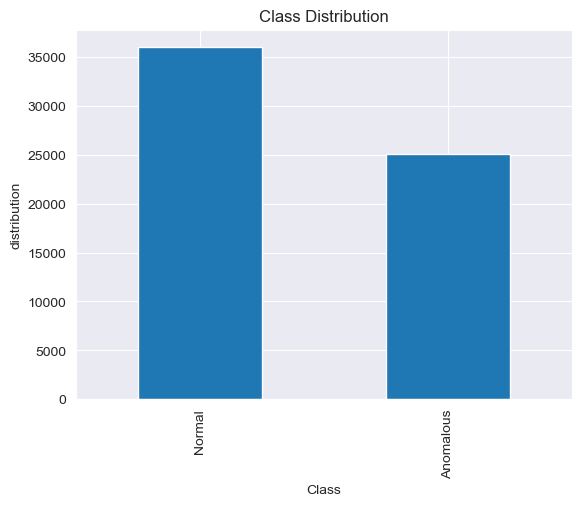

In [21]:
csic_data['Unnamed: 0'].value_counts().plot(kind = 'bar', xlabel ="Class", ylabel="distribution", title="Class Distribution")

<Axes: ylabel='count'>

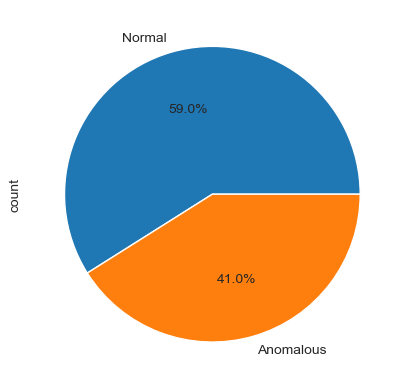

In [20]:
csic_data['Unnamed: 0'].value_counts().plot(kind = 'pie', autopct = "%1.1f%%")

Dropping samples with at least 1 NaN value will make to lose all the other Request Methods besides POST, this option is discarded since dropping data is not usually a good choice

In [ ]:
csic_data.head()

Visualizing URL format

In [12]:
csic_data.URL[1]

'http://localhost:8080/tienda1/publico/anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito HTTP/1.1'

In [13]:
feature_names=[ 'Unnamed: 0','Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content','classification',
        'URL']

X=csic_data[feature_names]
print(X)

      Unnamed: 0 Method                                         User-Agent  \
0         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
1         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
2         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
3         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
4         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
...          ...    ...                                                ...   
61060  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61061  Anomalous   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61062  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61063  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61064  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   

         Pragma Cache-Control  \
0      no-cache      no-cache 

# **Removing not discriminatory features**

**Enumerating unique values for each feature**

In [14]:
for feature in csic_data.columns:
    if feature in csic_data.columns:
        unique_count = csic_data[feature].nunique()
        print(f"Number of unique values for {feature}: {unique_count}")
    else:
        print(f"Column '{feature}' does not exist in the DataFrame.")

Number of unique values for Unnamed: 0: 2
Number of unique values for Method: 3
Number of unique values for User-Agent: 1
Number of unique values for Pragma: 1
Number of unique values for Cache-Control: 1
Number of unique values for Accept: 1
Number of unique values for Accept-encoding: 1
Number of unique values for Accept-charset: 1
Number of unique values for language: 1
Number of unique values for host: 2
Number of unique values for cookie: 61065
Number of unique values for content-type: 1
Number of unique values for connection: 2
Number of unique values for lenght: 382
Number of unique values for content: 12091
Number of unique values for classification: 2
Number of unique values for URL: 13498


In [15]:
# Removing not discriminatory Features and making some adjustments on feature names
X = X.rename(columns={'Unnamed: 0': 'Class'})
X = X.rename(columns={'lenght': 'content_length'})


feature_names=[ 'Class','Method','host','cookie','Accept', 'content_length', 'content','classification','URL']

# Print the remaining data
X = X[feature_names]
print(X)

           Class Method            host  \
0         Normal    GET  localhost:8080   
1         Normal    GET  localhost:8080   
2         Normal   POST  localhost:8080   
3         Normal    GET  localhost:8080   
4         Normal   POST  localhost:8080   
...          ...    ...             ...   
61060  Anomalous    GET  localhost:8080   
61061  Anomalous   POST  localhost:8080   
61062  Anomalous    GET  localhost:8080   
61063  Anomalous    GET  localhost:8080   
61064  Anomalous    GET  localhost:8080   

                                            cookie  \
0      JSESSIONID=1F767F17239C9B670A39E9B10C3825F4   
1      JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5   
2      JSESSIONID=933185092E0B668B90676E0A2B0767AF   
3      JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0   
4      JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2   
...                                            ...   
61060  JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275   
61061  JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3 

In [16]:
y=X.Class
print(y)


0           Normal
1           Normal
2           Normal
3           Normal
4           Normal
           ...    
61060    Anomalous
61061    Anomalous
61062    Anomalous
61063    Anomalous
61064    Anomalous
Name: Class, Length: 61065, dtype: object


In [17]:
size=X.shape[1]
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length', 'content', 'URL']


Load Models

# **Pre-processing on the feature: Content Length**

In [18]:
print(X.content_length)

0                        NaN
1                        NaN
2         Content-Length: 68
3                        NaN
4         Content-Length: 63
                ...         
61060                    NaN
61061    Content-Length: 255
61062                    NaN
61063                    NaN
61064                    NaN
Name: content_length, Length: 61065, dtype: object


Operations on the 'content_lenght' feature

In [19]:
#replace NaN values with 0
#removing the 'Content-Lenght' string and keeping only the numerical value

X['content_length'] = X['content_length'].astype(str)
X['content_length'] = X['content_length'].str.extract(r'(\d+)')
X['content_length'] = pd.to_numeric(X['content_length'], errors='coerce').fillna(0)
print(X.content_length)


0          0.0
1          0.0
2         68.0
3          0.0
4         63.0
         ...  
61060      0.0
61061    255.0
61062      0.0
61063      0.0
61064      0.0
Name: content_length, Length: 61065, dtype: float64


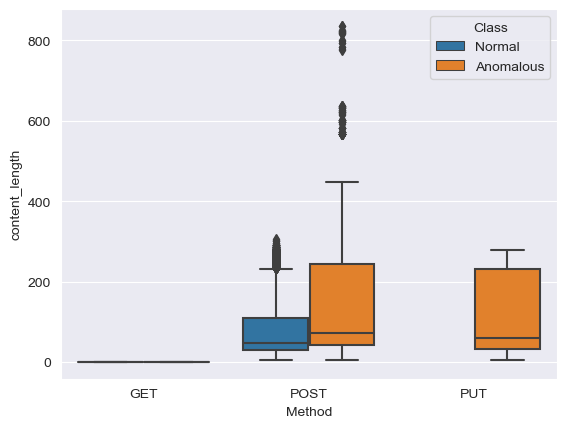

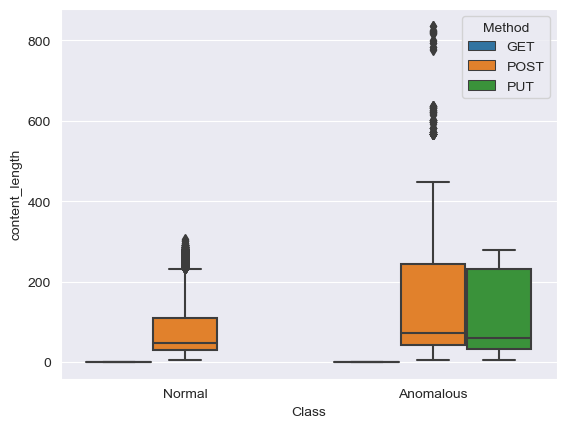

In [20]:
#Plot Dataset based on the features"Method" and "Content_Length" for each class

sns.boxplot(data=X, x='Method', y='content_length', hue='Class')
plt.show()
sns.boxplot(data=X, x='Class', y='content_length', hue='Method')
plt.show()

GET methods have the content_length set to 0 since they where all NaN (this method does not have to provide content)

In [21]:
filtered_length = X.loc[X['Method'] == 'GET', 'content_length']
print(filtered_length)


0        0.0
1        0.0
3        0.0
5        0.0
7        0.0
        ... 
61058    0.0
61060    0.0
61062    0.0
61063    0.0
61064    0.0
Name: content_length, Length: 43088, dtype: float64


# URL PRE-PROCESSING

In [22]:
url_counts = X['URL'].value_counts()
most_common_urls = url_counts.head(10)  # Extract the top 10 most common strings

print("Most common URLs:")
for i, (url, count) in enumerate(most_common_urls.items(), 1):
    print(f"{i}. URL: {url} - Count: {count}")


Most common URLs:
1. URL: http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1 - Count: 2441
2. URL: http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1 - Count: 2422
3. URL: http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 - Count: 2417
4. URL: http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1 - Count: 2412
5. URL: http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1 - Count: 2379
6. URL: http://localhost:8080/tienda1/publico/caracteristicas.jsp HTTP/1.1 - Count: 2003
7. URL: http://localhost:8080/tienda1/publico/vaciar.jsp HTTP/1.1 - Count: 1965
8. URL: http://localhost:8080/tienda1/publico/entrar.jsp HTTP/1.1 - Count: 1938
9. URL: http://localhost:8080/tienda1/index.jsp HTTP/1.1 - Count: 1000
10. URL: http://localhost:8080/tienda1/miembros/salir.jsp HTTP/1.1 - Count: 1000


**Utils for URL/Content pre-processing**

In [23]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')


def count_equal(url):
    return url.count('=')


def url_length(url):
    return len(str(url))

#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)


import re

def suspicious_words(url):
    score_map = {
        'error': 30,
        'errorMsg': 30,
        'id': 10,
        'errorID': 30,
        'SELECT': 50,
        'FROM': 50,
        'WHERE': 50,
        'DELETE': 50,
        'USERS': 50,
        'DROP': 50,
        'CREATE': 50,
        'INJECTED': 50,
        'TABLE': 50,
        'alert': 30,
        'javascript': 20,
        'cookie': 25,
        '--': 30,
        '.exe': 30,
        '.php': 20,
        '.js': 10,
        'admin': 10,
        'administrator': 10,
        '\'': 30,
        'password': 15,
        'login': 15,
        'incorrect': 20,
        'pwd': 15,
        'tamper': 25,
        'vaciar': 20,
        'carrito': 25,
        'wait': 30,
        'delay': 35,
        'set': 20,
        'steal': 35,
        'hacker': 35,
        'proxy': 35,
        'location': 30,
        'document.cookie': 40,
        'document': 20,
        'set-cookie': 40,
        'create': 40,
        'cmd': 40,
        'dir': 30,
        'shell': 40,
        'reverse': 30,
        'bin': 20,
        'cookiesteal': 40,
        'LIKE': 30,
        'UNION': 35,
        'include': 30,
        'file': 20,
        'tmp': 25,
        'ssh': 40,
        'exec': 30,
        'cat': 25,
        'etc': 30,
        'fetch': 25,
        'eval': 30,
        'wait': 30,
        'malware': 45,
        'ransomware': 45,
        'phishing': 45,
        'exploit': 45,
        'virus': 45,
        'trojan': 45,
        'backdoor': 45,
        'spyware': 45,
        'rootkit': 45,
        'credential': 30,
        'inject': 30,
        'script': 25,
        'iframe': 25,
        'src=': 25,
        'onerror': 30,
        'prompt': 20,
        'confirm': 20,
        'eval': 25,
        'expression': 30,
        'function\(': 20,
        'xmlhttprequest': 30,
        'xhr': 20,
        'window.': 20,
        'document.': 20,
        'cookie': 25,
        'click': 15,
        'mouseover': 15,
        'onload': 20,
        'onunload': 20,
    }

    matches = re.findall(r'(?i)' + '|'.join(score_map.keys()), url)

    total_score = sum(score_map.get(match.lower(), 0) for match in matches)
    return total_score


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

def count_special_characters(url):
    special_characters = re.sub(r'[a-zA-Z0-9\s]', '', url)
    count = len(special_characters)
    return count


# Number of Parameters in URL
def number_of_parameters(url):
    params = urlparse(url).query
    return 0 if params == '' else len(params.split('&'))

# Number of Fragments in URL
def number_of_fragments(url):
    frags = urlparse(url).fragment
    return len(frags.split('#')) - 1 if frags == '' else 0

# URL is Encoded
def is_encoded(url):
    return int('%' in url.lower())


def unusual_character_ratio(url):
    total_characters = len(url)
    unusual_characters = re.sub(r'[a-zA-Z0-9\s\-._]', '', url)
    unusual_count = len(unusual_characters)
    ratio = unusual_count / total_characters if total_characters > 0 else 0
    return ratio



In [24]:
X

,Class,Method,host,cookie,Accept,content_length,content,classification,URL
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,"text/xml,application/xml,application/xhtml+xml...",68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,"text/xml,application/xml,application/xhtml+xml...",63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...
...,...,...,...,...,...,...,...,...,...
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,"text/xml,application/xml,application/xhtml+xml...",255.0,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...


In [25]:
X['count_dot_url'] = X['URL'].apply(count_dot)
X['count_dir_url'] = X['URL'].apply(no_of_dir)
X['count_embed_domain_url'] = X['URL'].apply(no_of_embed)
X['short_url'] = X['URL'].apply(shortening_service)
X['count-http'] = X['URL'].apply(count_http)
X['count%_url'] = X['URL'].apply(count_per)
X['count?_url'] = X['URL'].apply(count_ques)
X['count-_url'] = X['URL'].apply(count_hyphen)
X['count=_url'] = X['URL'].apply(count_equal)
X['hostname_length_url'] = X['URL'].apply(hostname_length)
X['sus_url'] = X['URL'].apply(suspicious_words)
X['count-digits_url'] = X['URL'].apply(digit_count)
X['count-letters_url'] = X['URL'].apply(letter_count)
X['url_length'] = X['URL'].apply(url_length)
X['number_of_parameters_url'] = X['URL'].apply(number_of_parameters)
X['number_of_fragments_url'] = X['URL'].apply(number_of_fragments)
X['is_encoded_url'] = X['URL'].apply(is_encoded)
X['special_count_url'] = X['URL'].apply(count_special_characters)
X['unusual_character_ratio_url'] = X['URL'].apply(unusual_character_ratio)



In [26]:
X

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,hostname_length_url,sus_url,count-digits_url,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,14,10,7,31,48,0,0,0,9,0.145833
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,14,115,15,86,126,5,0,1,24,0.174603
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,"text/xml,application/xml,application/xhtml+xml...",68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,14,40,7,39,57,0,0,0,10,0.140351
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,14,40,11,92,125,5,0,1,21,0.152000
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,"text/xml,application/xml,application/xhtml+xml...",63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,14,10,7,43,61,0,0,0,10,0.131148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,14,80,47,218,314,13,0,1,48,0.143312
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,"text/xml,application/xml,application/xhtml+xml...",255.0,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,2,...,14,10,7,40,58,0,0,0,10,0.137931
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,14,10,7,43,62,0,0,0,11,0.129032
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,2,...,14,0,8,34,54,0,0,0,11,0.166667


In [27]:
# Select the features and class variable for plotting
new_features = ['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'number_of_fragments_url', 'is_encoded_url','special_count_url','unusual_character_ratio_url']

# Create a DataFrame with the selected features
set = X[new_features]

for new_feature in X.columns:
    if new_feature in X.columns:
        unique_count = X[new_feature].nunique()
        print(f"Number of unique values for {new_feature}: {unique_count}")
    else:
        print(f"Column '{new_feature}' does not exist in the DataFrame.")



Number of unique values for Class: 2
Number of unique values for Method: 3
Number of unique values for host: 2
Number of unique values for cookie: 61065
Number of unique values for Accept: 1
Number of unique values for content_length: 383
Number of unique values for content: 12091
Number of unique values for classification: 2
Number of unique values for URL: 13498
Number of unique values for count_dot_url: 9
Number of unique values for count_dir_url: 7
Number of unique values for count_embed_domain_url: 2
Number of unique values for short_url: 2
Number of unique values for count-http: 2
Number of unique values for count%_url: 34
Number of unique values for count?_url: 2
Number of unique values for count-_url: 8
Number of unique values for count=_url: 5
Number of unique values for hostname_length_url: 5
Number of unique values for sus_url: 61
Number of unique values for count-digits_url: 112
Number of unique values for count-letters_url: 259
Number of unique values for url_length: 417
N

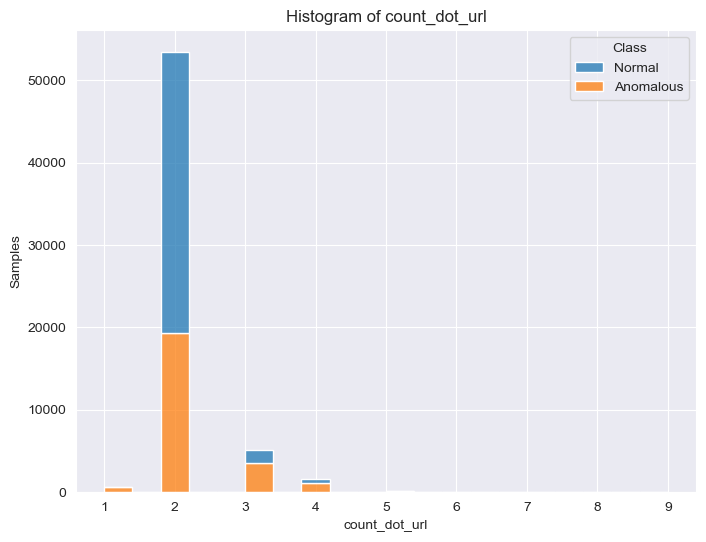

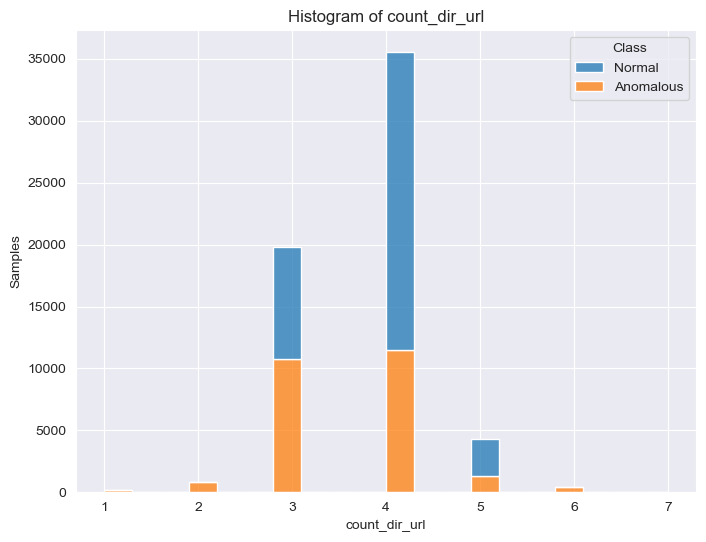

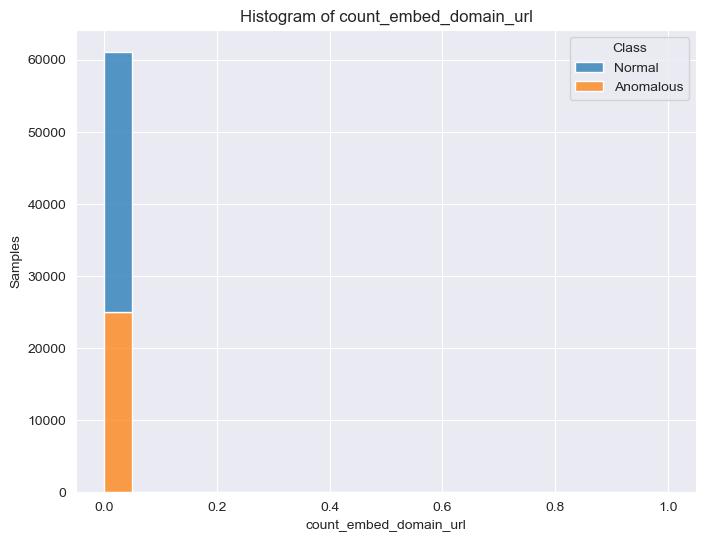

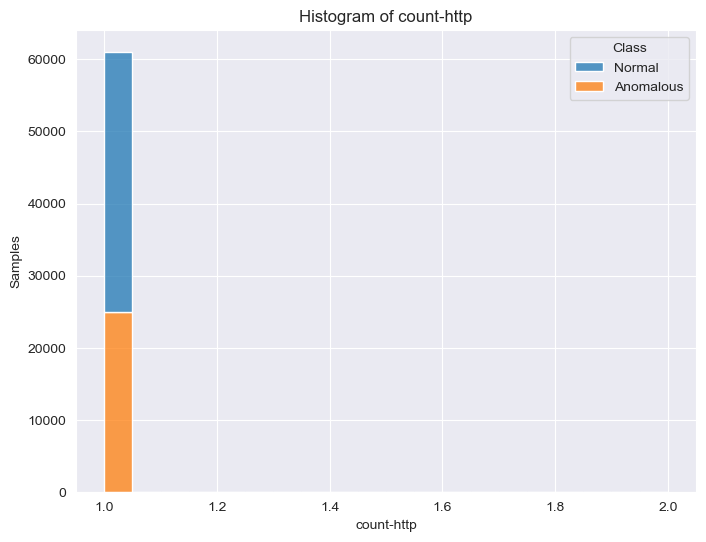

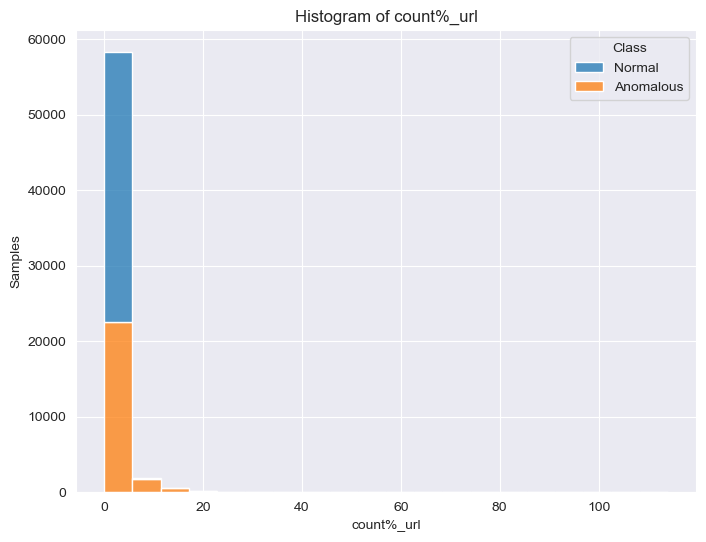

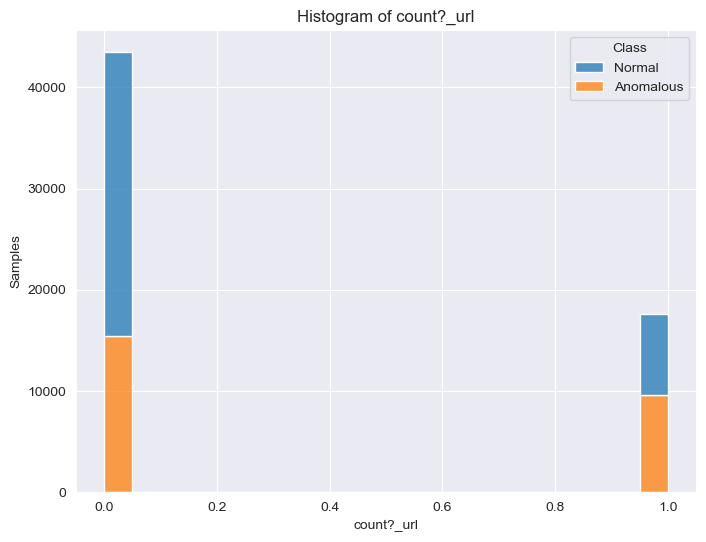

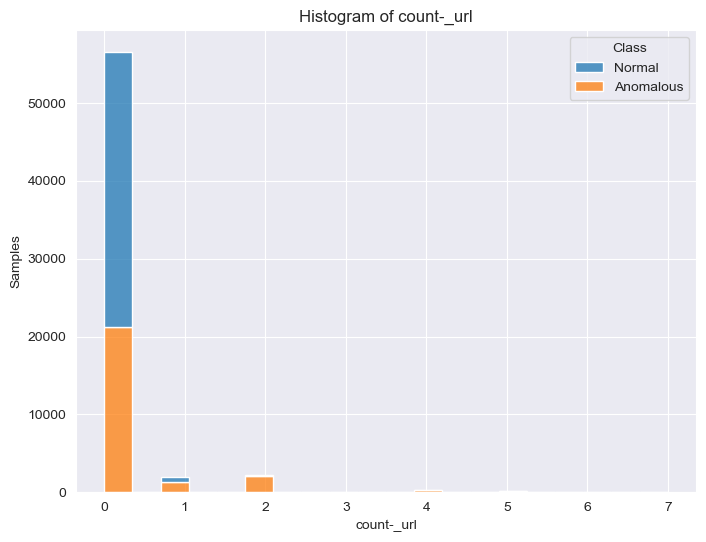

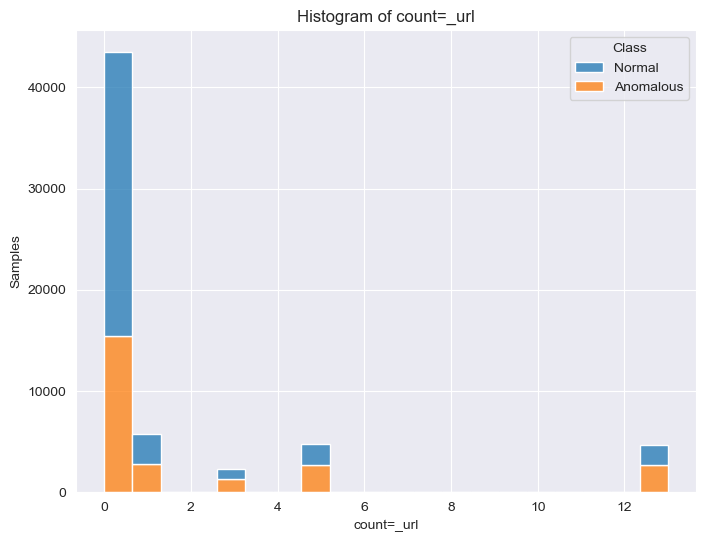

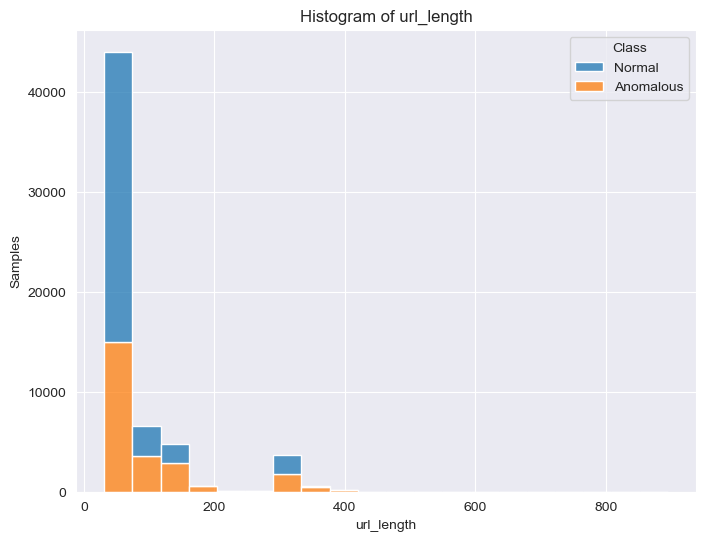

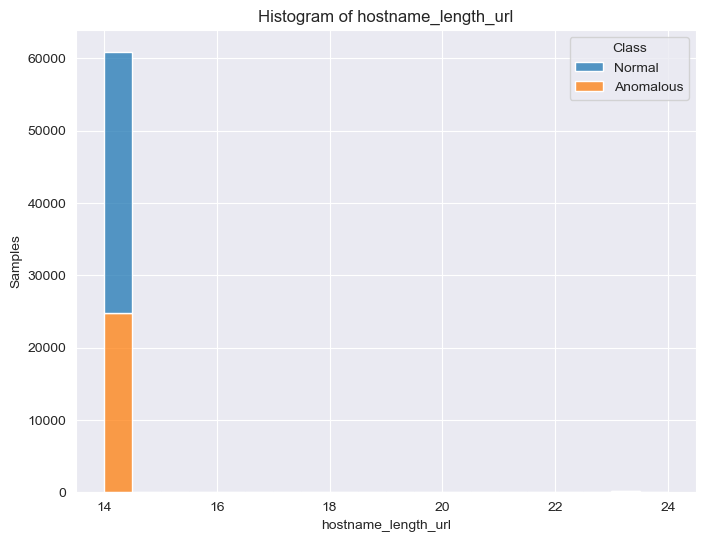

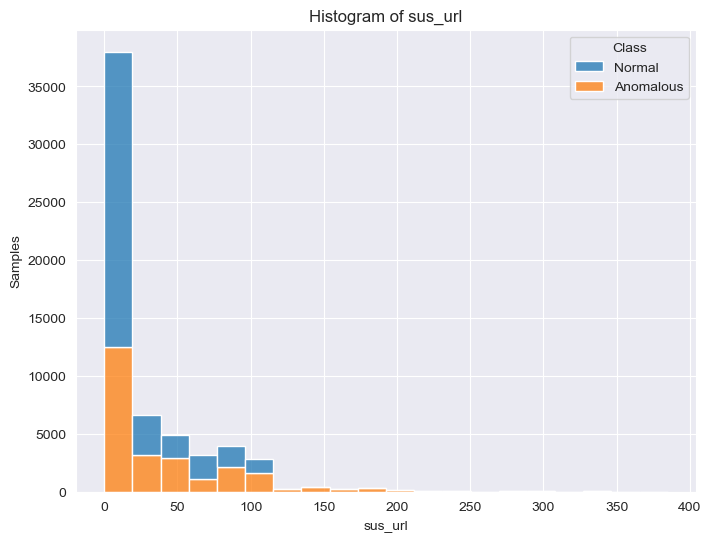

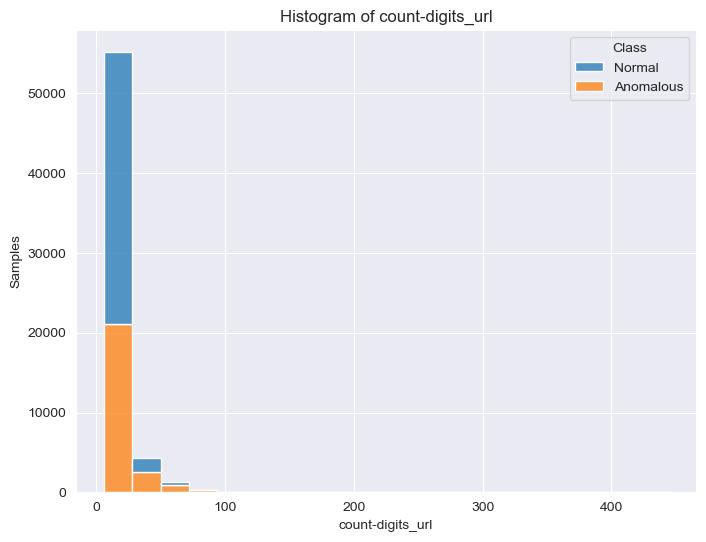

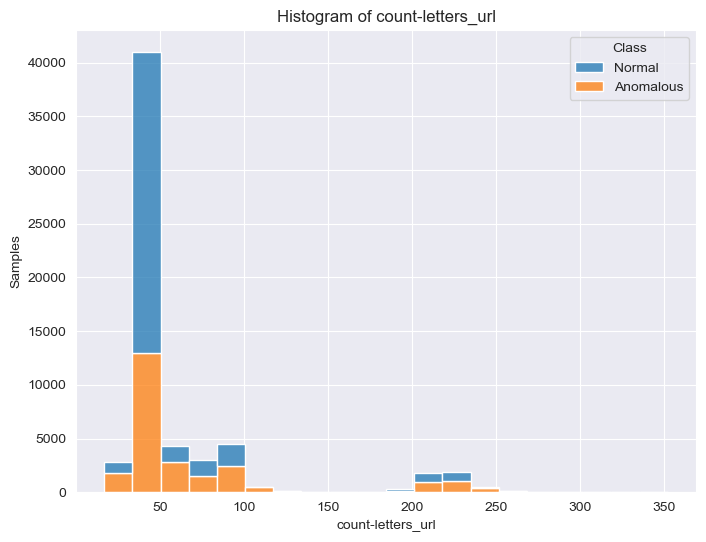

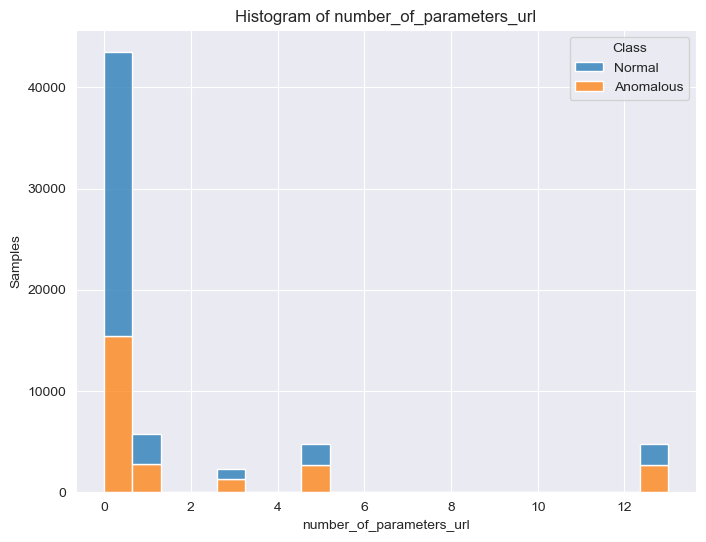

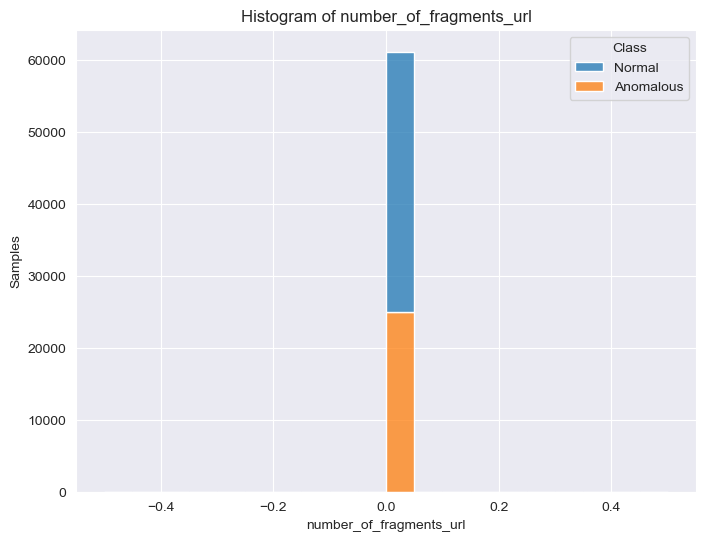

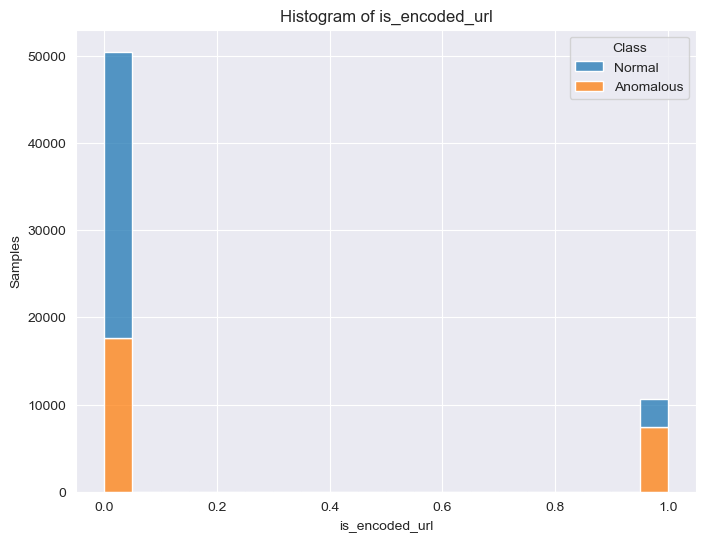

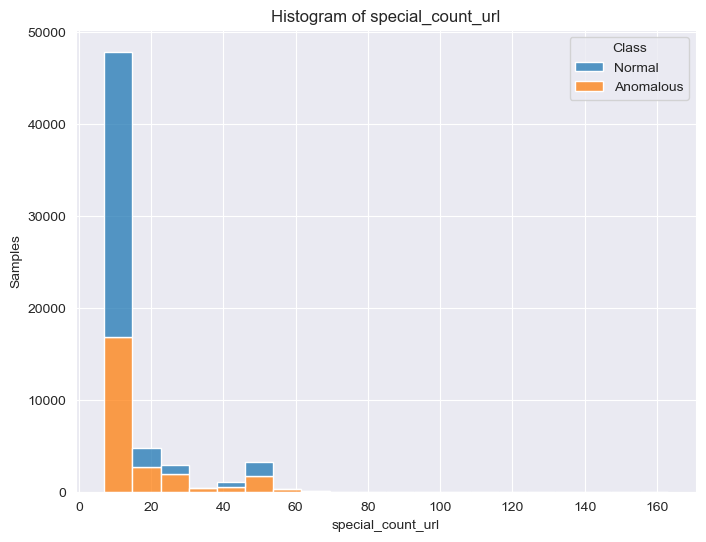

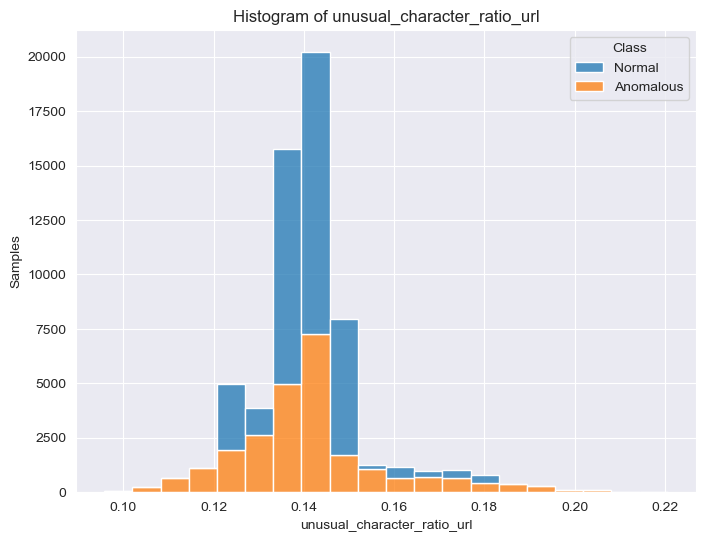

In [28]:
# Create a histogram for each feature
for feature in new_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X, x=feature, hue='Class', multiple='stack', bins=20, legend=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Samples')
    plt.show()


In [29]:
X.head()

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,hostname_length_url,sus_url,count-digits_url,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,14,10,7,31,48,0,0,0,9,0.145833
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,14,115,15,86,126,5,0,1,24,0.174603
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,"text/xml,application/xml,application/xhtml+xml...",68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,14,40,7,39,57,0,0,0,10,0.140351
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,"text/xml,application/xml,application/xhtml+xml...",0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,14,40,11,92,125,5,0,1,21,0.152000
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,"text/xml,application/xml,application/xhtml+xml...",63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,14,10,7,43,61,0,0,0,10,0.131148


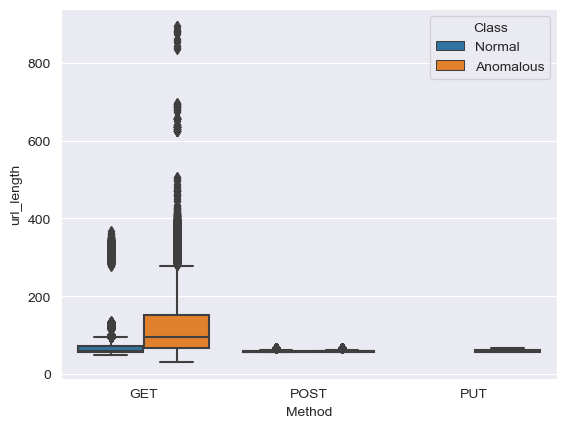

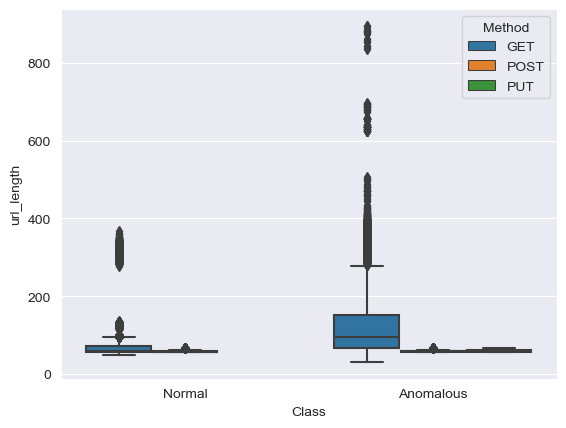

In [30]:
#Plot Dataset based on the features"Method" and "Content_Length" for each class

sns.boxplot(data=X, x='Method', y='url_length', hue='Class')
plt.show()
sns.boxplot(data=X, x='Class', y='url_length', hue='Method')
plt.show()

# Removing Cookies as feature
 **cookies are unique for each sample, this feature cannot be used as discriminant**

In [31]:
unique_count = X['cookie'].nunique()
print(f"Count of unique values in 'cookie': {unique_count}")


Count of unique values in 'cookie': 61065


# Encoding categorical features

In [32]:
X['Accept'] = X['Accept'].astype(str)
X['Accept'] = X['Accept'].str.extract(r'(\d+)')
X['Accept'] = pd.to_numeric(X['Accept'], errors='coerce').fillna(1)

In [33]:
lb_make = LabelEncoder()
X["Method_enc"] = lb_make.fit_transform(X["Method"])
X["host_enc"] =lb_make.fit_transform(X["host"])
X["Accept_enc"] =lb_make.fit_transform(X["Accept"])


In [34]:
unique_count_met = X["Method_enc"].nunique()
unique_count_host = X["host_enc"].nunique()
unique_count_acc = X["Accept_enc"].nunique()


print(f"Number of unique values for 'Method_enc': {unique_count_met}")
print(f"Number of unique values for 'host_enc': {unique_count_host}")
print(f"Number of unique values for 'Accept_enc': {unique_count_acc}")





Number of unique values for 'Method_enc': 3
Number of unique values for 'host_enc': 2
Number of unique values for 'Accept_enc': 2


In [35]:
X.head()



,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,0.0,0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,31,48,0,0,0,9,0.145833,0,0,0
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,86,126,5,0,1,24,0.174603,0,0,0
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,0.0,68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,39,57,0,0,0,10,0.140351,1,0,0
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,92,125,5,0,1,21,0.152000,0,0,0
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,0.0,63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,43,61,0,0,0,10,0.131148,1,0,0


In [36]:
X.tail()

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,218,314,13,0,1,48,0.143312,0,0,0
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,0.0,255.0,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,2,...,40,58,0,0,0,10,0.137931,1,0,0
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,43,62,0,0,0,11,0.129032,0,0,0
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,2,...,34,54,0,0,0,11,0.166667,0,0,0
61064,Anomalous,GET,localhost:8080,JSESSIONID=3CC12010CDA952F123240EBAD79B55CC,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/nuestra...,3,...,50,69,0,0,0,11,0.115942,0,0,0


In [37]:
def apply_to_content(content,function):
    if pd.isna(content):
        return 0
    elif isinstance(content, str):
        return function(content)

#"""
#                'count_dot_content','count_dir_content','count_embed_domain_content','count%_content','count?_content',
 #               'count-_content','count=_content','hostname_length_content','sus_content','count_digits_content',
  #              'count_letters_content','content_length','number_of_parameters_content','number_of_fragments_content',
   #             'is_encoded_content','special_count_content','unusual_character_ratio_content'
    #            ]"""

X['count_dot_content'] = X['content'].apply(apply_to_content, function=count_dot)
X['count_dir_content'] = X['content'].apply(apply_to_content, function=no_of_dir)
X['count_embed_domain_content'] = X['content'].apply(apply_to_content, function=no_of_embed)
X['count%_content'] = X['content'].apply(apply_to_content, function=count_per)
X['count?_content'] = X['content'].apply(apply_to_content, function=count_ques)
X['count-_content'] = X['content'].apply(apply_to_content, function=count_hyphen)
X['count=_content'] = X['content'].apply(apply_to_content, function=count_equal)
X['content_length'] = X['content'].apply(apply_to_content, function=url_length)
X['sus_content'] = X['content'].apply(apply_to_content, function=suspicious_words)
X['count_digits_content'] = X['content'].apply(apply_to_content, function=digit_count)
X['count_letters_content'] = X['content'].apply(apply_to_content, function=letter_count)
X['special_count_content'] = X['content'].apply(apply_to_content, function=count_special_characters)
X['is_encoded_content'] = X['content'].apply(apply_to_content, function=is_encoded)
#X['unusual_character_ratio_content'] = X['content'].apply(apply_to_content, function=unusual_character_ratio)






In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features and class variable for plotting
new_content_features = ['count_dot_content', 'count_dir_content', 'count_embed_domain_content', 'count%_content', 'count?_content',
                        'count-_content', 'count=_content', 'sus_content', 'count_digits_content',
                        'count_letters_content', 'content_length', 'is_encoded_content', 'special_count_content']

# Create a DataFrame with the selected features
selected_features_df = X[new_content_features]

for feature_name in selected_features_df.columns:
    if feature_name in X.columns:
        unique_count = selected_features_df[feature_name].nunique()
        print(f"Number of unique values for {feature_name}: {unique_count}")
    else:
        print(f"Column '{feature_name}' does not exist in the DataFrame.")


Number of unique values for count_dot_content: 8
Number of unique values for count_dir_content: 1
Number of unique values for count_embed_domain_content: 1
Number of unique values for count%_content: 34
Number of unique values for count?_content: 1
Number of unique values for count-_content: 8
Number of unique values for count=_content: 5
Number of unique values for sus_content: 57
Number of unique values for count_digits_content: 111
Number of unique values for count_letters_content: 230
Number of unique values for content_length: 383
Number of unique values for is_encoded_content: 2
Number of unique values for special_count_content: 87


In [39]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

new_content_features: ['count_dot_content', 'count_dir_content', 'count_embed_domain_content', 'count%_content', 'count?_content', 'count-_content', 'count=_content', 'sus_content', 'count_digits_content', 'count_letters_content', 'content_length', 'is_encoded_content', 'special_count_content']
X columns: Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content',

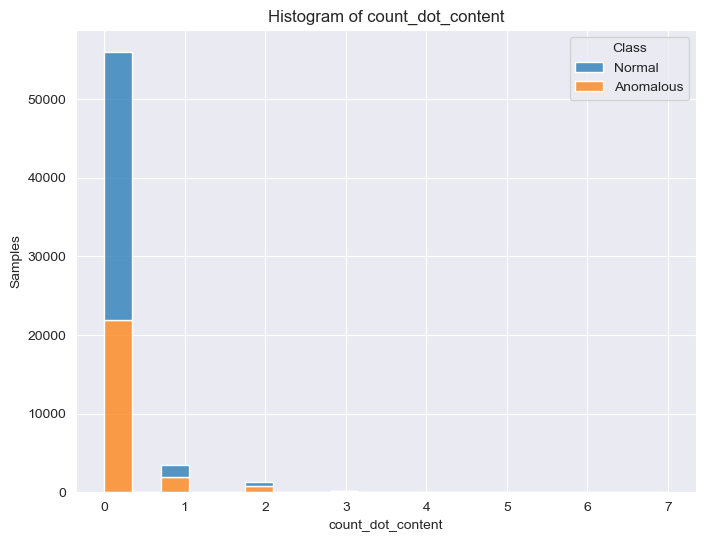

Current feature: count_dir_content


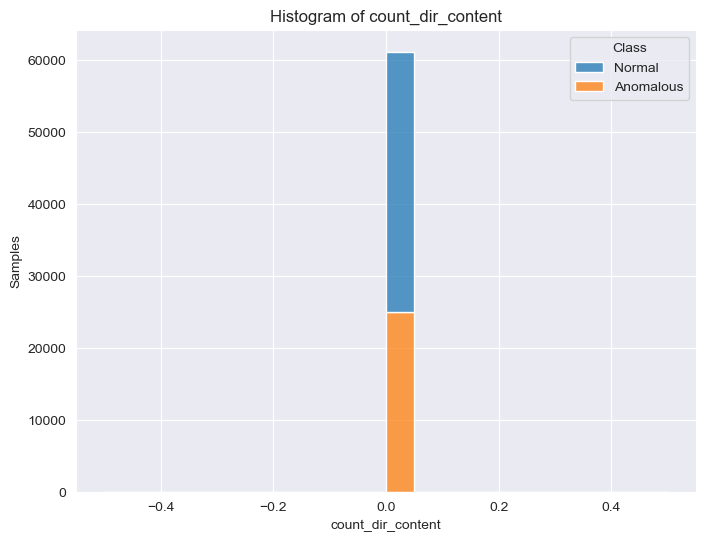

Current feature: count_embed_domain_content


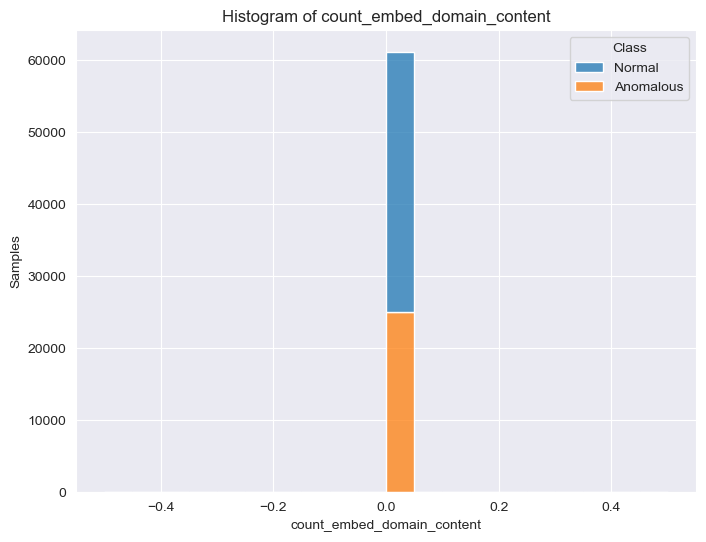

Current feature: count%_content


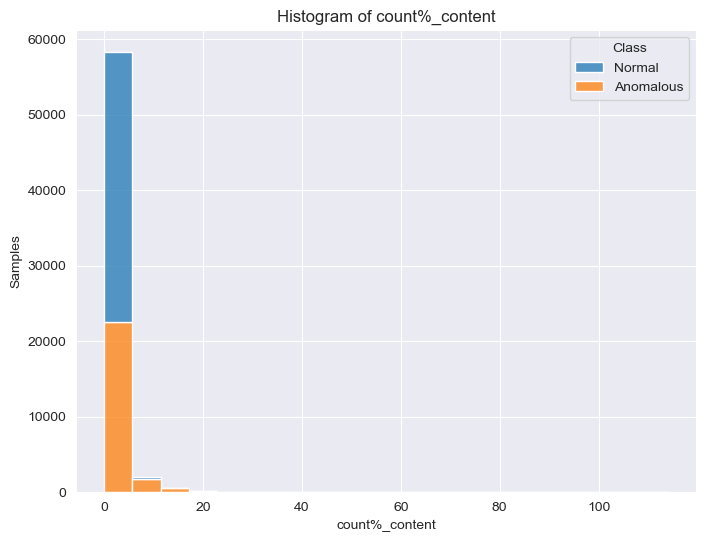

Current feature: count?_content


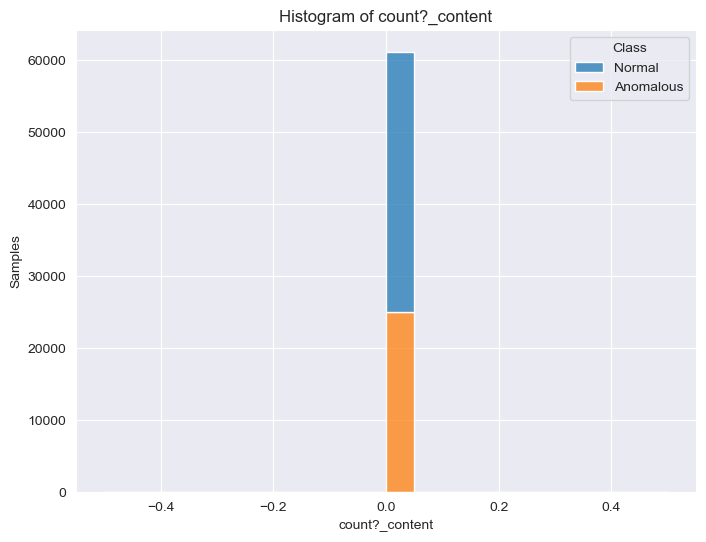

Current feature: count-_content


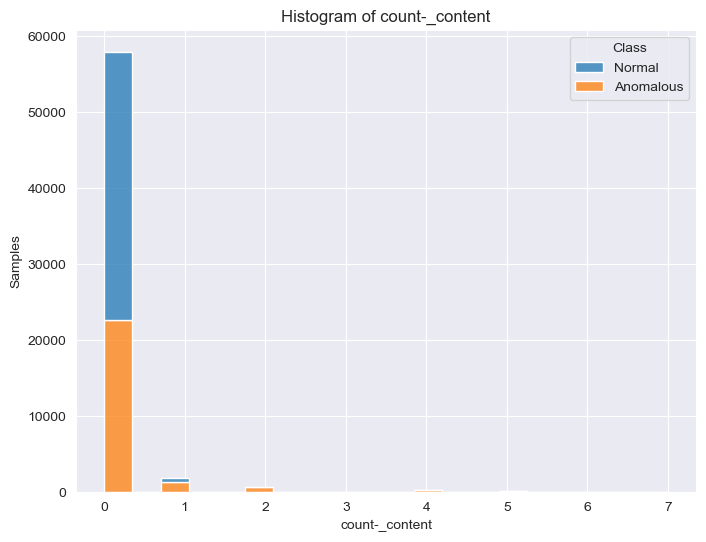

Current feature: count=_content


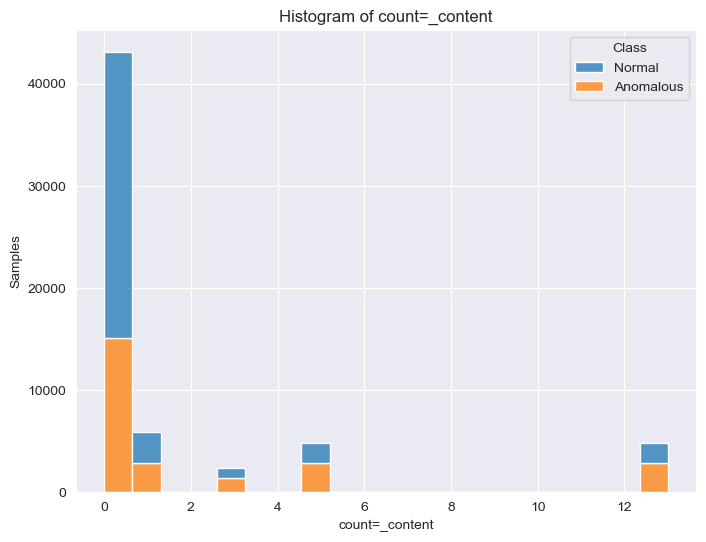

Current feature: sus_content


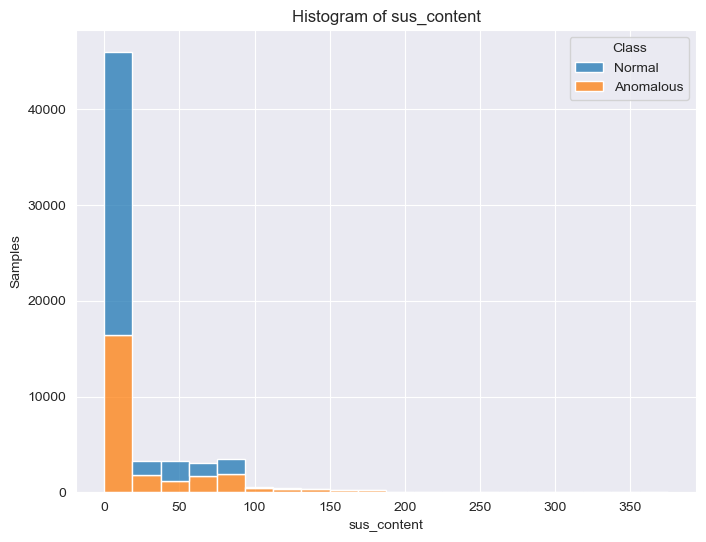

Current feature: count_digits_content


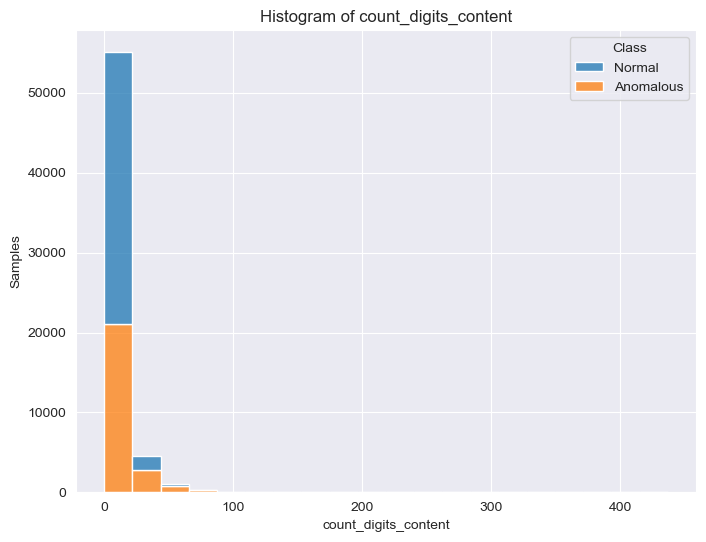

Current feature: count_letters_content


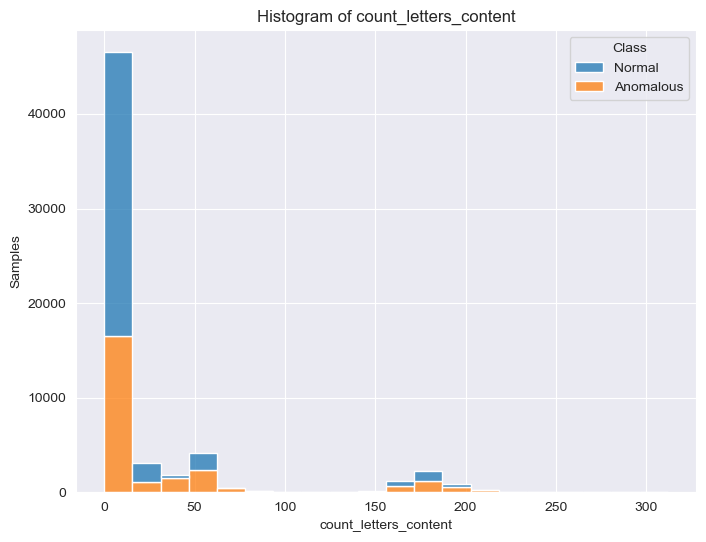

Current feature: content_length


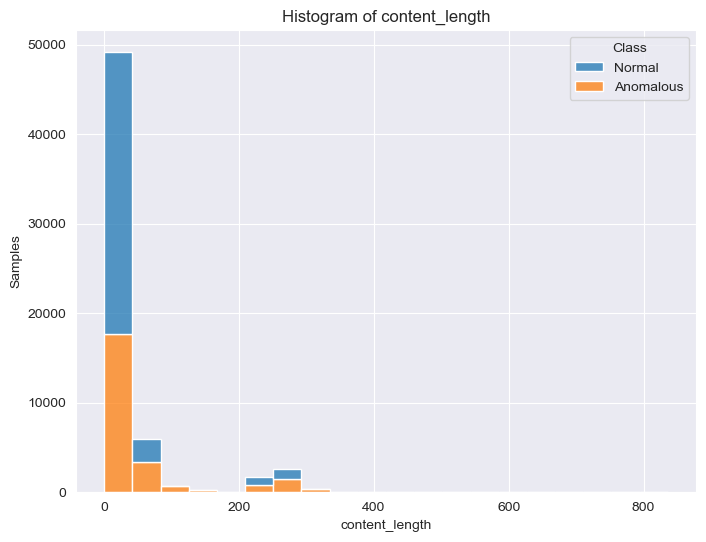

Current feature: is_encoded_content


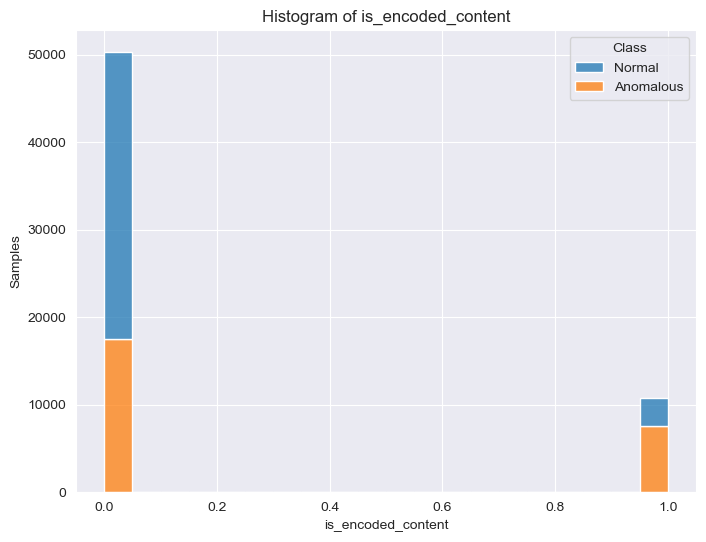

Current feature: special_count_content


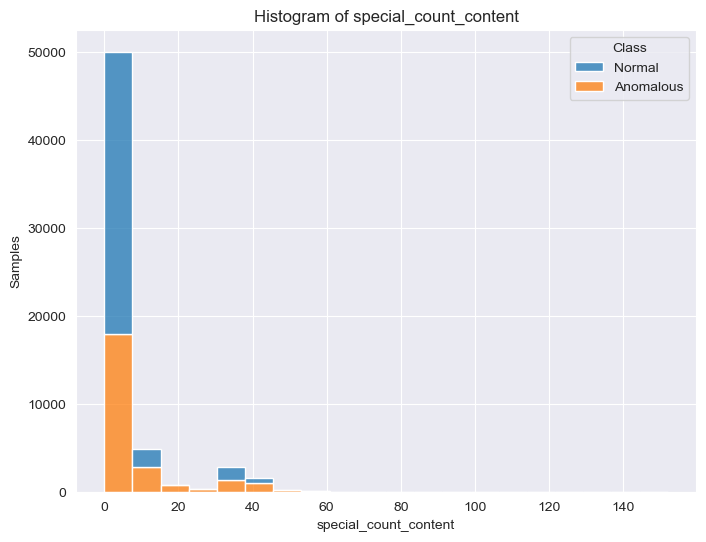

In [40]:
# Check that new_content_features and X are defined correctly
print("new_content_features:", new_content_features)
print("X columns:", X.columns)

# Create a histogram for each feature
for feature in new_content_features:
    print("Current feature:", feature)  # Debugging line

    # Check if the feature exists in the dataset
    if feature not in X.columns:
        print(f"Feature {feature} not found in the dataset.")
        continue
    
    # Check if the feature is numeric
    if not pd.api.types.is_numeric_dtype(X[feature]):
        print(f"Feature {feature} is not numeric. Histogram cannot be created.")
        continue

    plt.figure(figsize=(8, 6))
    sns.histplot(data=X, x=feature, hue='Class', multiple='stack', bins=20, legend=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Samples')
    plt.show()


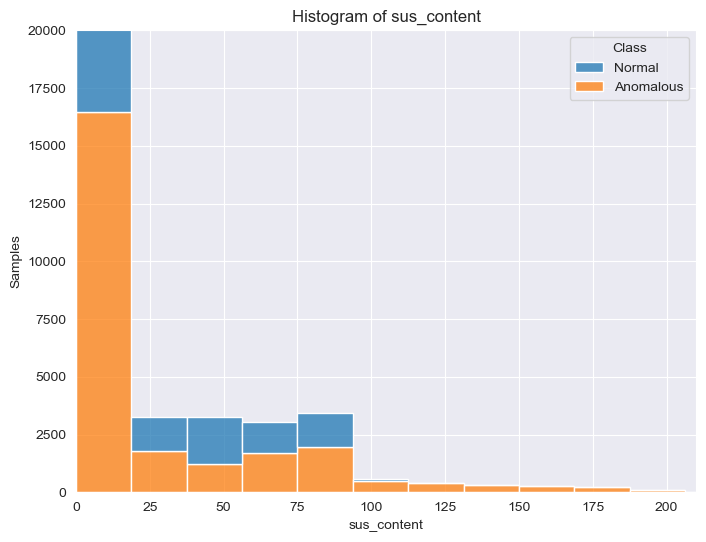

In [41]:
#zooming for better visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=X, x='sus_content', hue='Class', multiple='stack', bins=20, legend=True)
plt.title(f'Histogram of sus_content')
plt.xlabel('sus_content')
plt.ylabel('Samples')

plt.xlim(0, 210) 
plt.ylim(0,20000)

plt.show()

# **Building the final dataset to use for the classification**

In [42]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

In [43]:
labels=['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'is_encoded_url','special_count_url','unusual_character_ratio_url',
                 #method
                'Method_enc',
                #content
                'count_dot_content','count%_content',
                 'count-_content','count=_content','sus_content','count_digits_content',
                  'count_letters_content','content_length',
               'is_encoded_content','special_count_content']
X[labels]

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
0,2,3,0,1,0,0,0,0,48,14,...,0,0,0,0,0,0,0,0,0,0
1,2,3,0,1,1,1,0,5,126,14,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,1,0,0,0,0,57,14,...,0,1,0,5,75,8,47,68,1,13
3,2,3,0,1,1,1,0,5,125,14,...,0,0,0,0,0,0,0,0,0,0
4,2,4,0,1,0,0,0,0,61,14,...,0,1,0,5,30,4,49,63,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61060,3,3,0,1,6,1,0,13,314,14,...,0,0,0,0,0,0,0,0,0,0
61061,2,4,0,1,0,0,0,0,58,14,...,1,6,0,13,70,40,178,255,1,37
61062,3,4,0,1,0,0,0,0,62,14,...,0,0,0,0,0,0,0,0,0,0
61063,2,5,0,1,0,0,0,0,54,14,...,0,0,0,0,0,0,0,0,0,0


In [44]:
y=X['classification']
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
61060    1
61061    1
61062    1
61063    1
61064    1
Name: classification, Length: 61065, dtype: int64


In [45]:
print('computing...)')
#split dataset in test and train 
x_tr, x_ts, y_tr, y_ts = train_test_split(X[labels], y, test_size=0.3, random_state=0)


print('Done!')


computing...)
Done!


In [46]:
x_tr.head(5)



,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
23480,2,3,0,1,0,1,0,1,91,14,...,0,0,0,0,0,0,0,0,0,0
45171,2,3,0,1,14,1,2,1,125,14,...,0,0,0,0,0,0,0,0,0,0
9460,2,4,0,1,0,0,0,0,57,14,...,0,0,0,0,0,0,0,0,0,0
9905,2,3,0,1,0,1,0,1,71,14,...,0,0,0,0,0,0,0,0,0,0
8937,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,31,33,0,2


In [47]:
x_tr.tail(5)

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
45891,2,3,0,1,0,1,0,1,76,14,...,0,0,0,0,0,0,0,0,0,0
52416,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,32,34,0,2
42613,2,3,0,1,0,1,0,3,95,14,...,0,0,0,0,0,0,0,0,0,0
43567,3,3,0,1,4,1,0,13,324,14,...,0,0,0,0,0,0,0,0,0,0
2732,2,4,0,1,0,0,0,0,53,14,...,0,0,0,0,0,0,0,0,0,0


# MODEL DEVELOPEMENT

**RANDOM FOREST**

In [48]:
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [49]:
RT_predictions= random_forest_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, RT_predictions))
print("Accuracy", accuracy_score(y_ts, RT_predictions))
print("Precision", precision_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_rt))


MAE 0.07374454148471615
Accuracy 0.9262554585152838
Precision 0.9261917594808624
Recall 0.9262554585152838
F1 0.9262150260558555
ROC AUC 0.9234171756395833
Test error: 7.4%


In [50]:
print(y_tr.unique())
print(y_tr.name)

[0 1]
classification


In [51]:
x_ts = x_ts.reset_index(drop=True)
y_ts = y_ts.reset_index(drop=True)

for k in range(np.unique(y_ts).size):
    print('mean of class ' + str(k) + ':\n', x_ts[y_ts == k].mean(axis=0))


mean of class 0:
 count_dot_url                   2.072631
count_dir_url                   3.831210
count_embed_domain_url          0.000000
count-http                      1.000000
count%_url                      0.273319
count?_url                      0.221706
count-_url                      0.024644
count=_url                      1.173812
url_length                     79.160606
hostname_length_url            14.000000
sus_url                        21.204315
count-digits_url                9.812703
count-letters_url              55.086766
number_of_parameters_url        1.173812
is_encoded_url                  0.090951
special_count_url              13.261136
unusual_character_ratio_url     0.140332
Method_enc                      0.226448
count_dot_content               0.073189
count%_content                  0.272110
count-_content                  0.024644
count=_content                  1.189529
sus_content                    10.676090
count_digits_content            2.77104

In [52]:
print(classification_report(y_ts, RT_predictions, target_names = ['Normal (class 0)','Anomalous (Class 1)']))

                     precision    recall  f1-score   support

   Normal (class 0)       0.93      0.94      0.94     10753
Anomalous (Class 1)       0.91      0.91      0.91      7567

           accuracy                           0.93     18320
          macro avg       0.92      0.92      0.92     18320
       weighted avg       0.93      0.93      0.93     18320



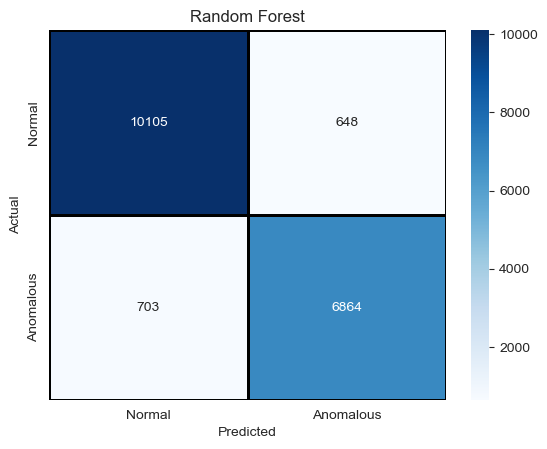

In [53]:


label = ['Normal', 'Anomalous']
cm = confusion_matrix(y_ts, RT_predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=label, yticklabels=label)
plt.title("Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**K-NEAREST NEIGHBOR**


In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#knn_model = KNeighborsClassifier()

#param_grid = {'n_neighbors': [3, 5, 7, 9,10,11, 13]}

#grid_search = GridSearchCV(knn_model, param_grid, cv=5)
#grid_search.fit(x_tr, y_tr)

#best_n_neighbors = grid_search.best_params_['n_neighbors']
#print("Best n_neighbors:", best_n_neighbors)

#final_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
#final_model.fit(x_tr, y_tr)

#knn_predictions = final_model.predict(x_ts)

Best n_neighbors: 9


In [55]:
final_model = KNeighborsClassifier(n_neighbors=9)
final_model.fit(x_tr, y_tr)
knn_predictions = final_model.predict(x_ts)

In [56]:
print('MAE', mean_absolute_error(y_ts, knn_predictions))
print("Accuracy", accuracy_score(y_ts, knn_predictions))
print("Precision", precision_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("Recall", recall_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("F1", f1_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("ROC AUC", roc_auc_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
error_knn = (knn_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_knn))

MAE 0.08471615720524017
Accuracy 0.9152838427947598
Precision 0.915150466570833
Recall 0.9152838427947598
F1 0.9151604867156559
ROC AUC 0.911251753162618
Test error: 8.5%


<Axes: title={'center': 'KN Neighbors'}>

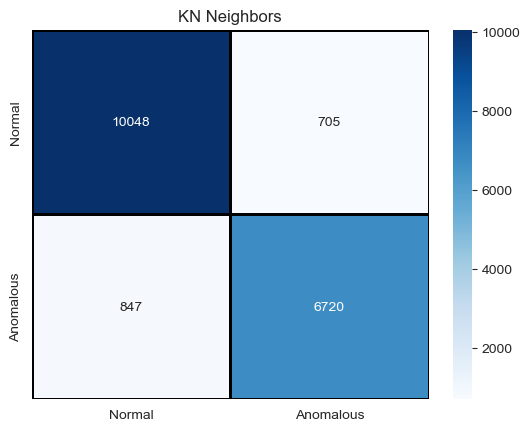

In [57]:
cm = confusion_matrix(y_ts,knn_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
# plt.figure(figsize = (10,10))
plt.title("KN Neighbors")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)


**DECISION TREE**

In [58]:
DT_model = DecisionTreeClassifier(random_state=2)
print('Computing....')
DT_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [59]:
DT_predictions= DT_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, DT_predictions))
print("Accuracy", accuracy_score(y_ts, DT_predictions))
print("Precision", precision_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("Recall", recall_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("F1", f1_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("ROC AUC", roc_auc_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
error_dt = (DT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_dt))

MAE 0.08133187772925764
Accuracy 0.9186681222707423
Precision 0.9185504062924272
Recall 0.9186681222707423
F1 0.9185072169864832
ROC AUC 0.9142717136873706
Test error: 8.1%


<Axes: title={'center': 'Decision Tree'}>

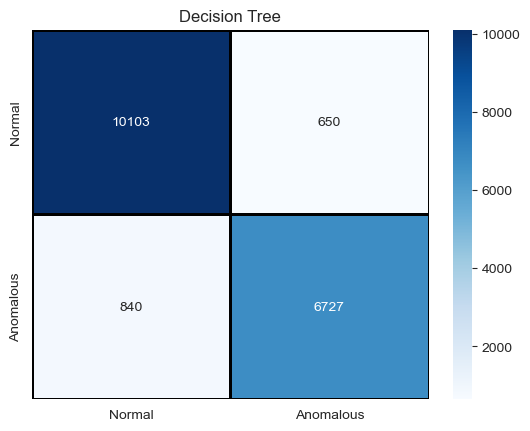

In [60]:
cm = confusion_matrix(y_ts,DT_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

# GB-Model

In [61]:
GB_model = XGBClassifier(learning_rate= 0.1, n_estimators= 500 )
GB_model.fit(x_tr,y_tr)
GB_predictions= GB_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, GB_predictions))
print("Accuracy", accuracy_score(y_ts, GB_predictions))
print("Precision", precision_score(y_ts, GB_predictions, average='weighted', labels=np.unique(GB_predictions)))
print("Recall", recall_score(y_ts, GB_predictions, average='weighted', labels=np.unique(GB_predictions)))
print("F1", f1_score(y_ts, GB_predictions, average='weighted', labels=np.unique(GB_predictions)))
print("ROC AUC", roc_auc_score(y_ts, GB_predictions, average='weighted', labels=np.unique(GB_predictions)))
error_gb = (GB_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_gb))

MAE 0.07816593886462882
Accuracy 0.9218340611353711
Precision 0.9217334755315677
Recall 0.9218340611353711
F1 0.9216724992146664
ROC AUC 0.9174580787956672
Test error: 7.8%


<Axes: title={'center': 'XGradient Boosting '}>

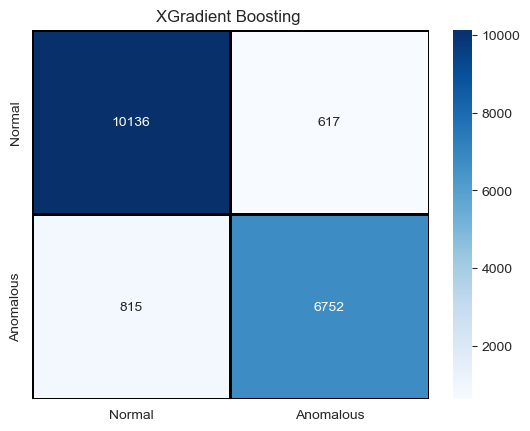

In [62]:
cm = confusion_matrix(y_ts,GB_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("XGradient Boosting ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**NEURAL NETWORK (Multi-layer perceptron)**

In [63]:
MLP_model = MLPClassifier(hidden_layer_sizes=(50,50),activation='relu',alpha=0.0001,learning_rate='adaptive',max_iter=500)
MLP_model.fit(x_tr,y_tr)
print('Done!')


Done!


In [64]:
MLP_predictions= MLP_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, MLP_predictions))
print("Accuracy", accuracy_score(y_ts, MLP_predictions))
print("Precision", precision_score(y_ts, MLP_predictions, average='weighted', labels=np.unique(MLP_predictions)))
print("Recall", recall_score(y_ts, MLP_predictions, average='weighted', labels=np.unique(MLP_predictions)))
print("F1", f1_score(y_ts, MLP_predictions, average='weighted', labels=np.unique(MLP_predictions)))
print("ROC AUC", roc_auc_score(y_ts, MLP_predictions, average='weighted', labels=np.unique(MLP_predictions)))
error_mlp = (MLP_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_mlp))

MAE 0.09443231441048035
Accuracy 0.9055676855895196
Precision 0.9070263292715411
Recall 0.9055676855895196
F1 0.9046997081291505
ROC AUC 0.8953005219462883
Test error: 9.4%


<Axes: title={'center': 'Multi-layer perceptron'}>

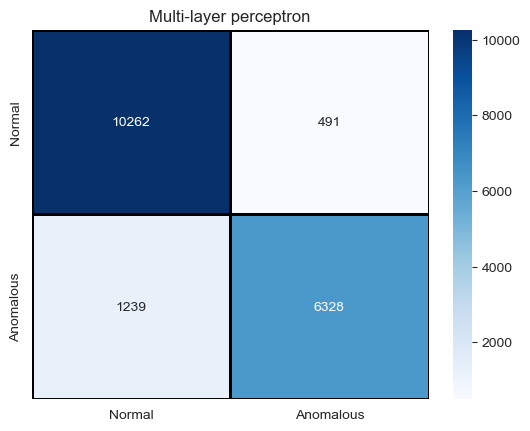

In [65]:
cm = confusion_matrix(y_ts,MLP_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Multi-layer perceptron")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

In [66]:
print(classification_report(y_ts, MLP_predictions, target_names = ['Normal (Class 0)','Anomalous (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.95      0.92     10753
Anomalous (Class 1)       0.93      0.84      0.88      7567

           accuracy                           0.91     18320
          macro avg       0.91      0.90      0.90     18320
       weighted avg       0.91      0.91      0.90     18320



**LINEAR SUPPORT VECTOR**

Best Score: 0.727968 using HyperParameters {'C': 0.1, 'max_iter': 300, 'penalty': 'l2'}

In [67]:
SVC_model = LinearSVC(max_iter=300,C=0.1, penalty='l2',random_state=10)
print('Computing....')
# Fit the model
SVC_model.fit(x_tr,y_tr)
print('Done!')

Computing....


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Done!


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [68]:
SVC_predictions= SVC_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, SVC_predictions))
print("Accuracy", accuracy_score(y_ts, SVC_predictions))
print("Precision", precision_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("Recall", recall_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("F1", f1_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("ROC AUC", roc_auc_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
error_svc = (SVC_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_svc))


MAE 0.2533296943231441
Accuracy 0.7466703056768559
Precision 0.7447421945476225
Recall 0.7466703056768559
F1 0.7429889579796548
ROC AUC 0.7281878647773741
Test error: 25.3%


<Axes: title={'center': 'Linear Supported Vector'}>

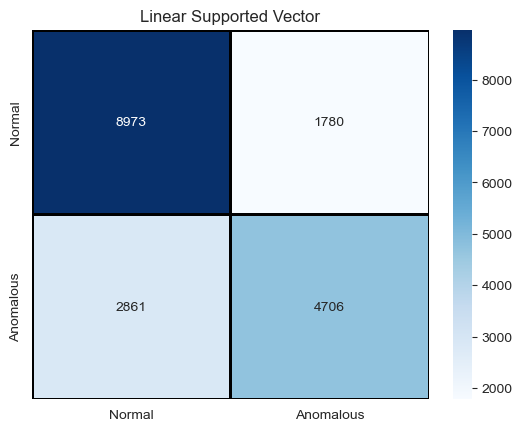

In [69]:
cm = confusion_matrix(y_ts,SVC_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Linear Supported Vector")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

The Linear SVC has to be tuned properly, not doing so results in a poor performance ranging from an accuracy spacing from the 46% circa to 75%.
* this task is too time consuming, due to this aspect the Linear SVC model is discarded

**STOCHASTIC GRADIENT DESCENT**

Best parameters:  {'alpha': 0.001, 'max_iter': 4000, 'penalty': 'l1'}
Best accuracy:  0.7472922667478515

In [70]:
SGD_model=SGDClassifier(alpha=0.001,max_iter=4000,penalty='l1')
SGD_model.fit(x_tr,y_tr)
SGD_predictions= SGD_model.predict(x_ts)
print("MAE",mean_absolute_error(y_ts,SGD_predictions))
print("Accuracy", accuracy_score(y_ts, SGD_predictions))
print("Precision", precision_score(y_ts, SGD_predictions, average='weighted', labels=np.unique(SGD_predictions)))
print("Recall", recall_score(y_ts, SGD_predictions, average='weighted', labels=np.unique(SGD_predictions)))
print("F1", f1_score(y_ts, SGD_predictions, average='weighted', labels=np.unique(SGD_predictions)))
print("ROC AUC", roc_auc_score(y_ts, SGD_predictions, average='weighted', labels=np.unique(SGD_predictions)))
error_sgd = (SGD_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_sgd))

MAE 0.22117903930131005
Accuracy 0.77882096069869
Precision 0.7783816532700646
Recall 0.77882096069869
F1 0.7753005279267235
ROC AUC 0.7605678923879993
Test error: 22.1%


<Axes: title={'center': 'Stochastic Gradient Descent'}>

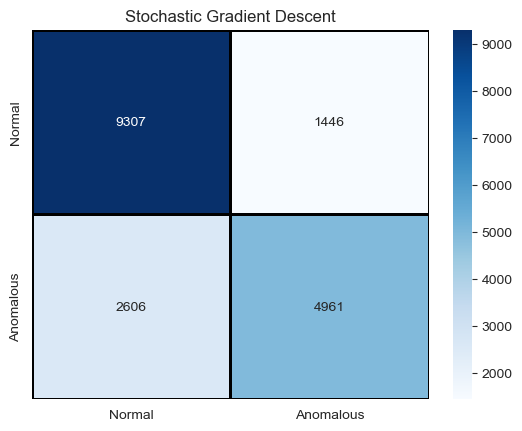

In [71]:
cm = confusion_matrix(y_ts,SGD_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Stochastic Gradient Descent")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

In [72]:
x_tr.shape

(42745, 28)

**DEEP NEURAL NETWORK**

In [73]:
def weighted_accuracy(class_weights):
    def accuracy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(y_true * y_pred * class_weights)
        true_positives_and_negatives = tf.reduce_sum(y_true * class_weights)
        return true_positives / (true_positives_and_negatives + tf.keras.backend.epsilon())
    return accuracy

In [74]:
# Define class weights for the two classes
Norm_W= 1 / 0.5865 # ≈ 1.706 the Normal set is the 58.6% of the total dataset
Mal_W= 1 / 0.4135  # ≈ 2.416 the Anomalous set is the 41.3% of the total dataset
class_weights = {0: Norm_W, 1: Mal_W}

Norm_W ≈ 1.706 & Mal_W ≈ 2.416 -> 89.2% accuracy

In [75]:
optimizer = 'Adam'
loss = 'categorical_crossentropy'
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=0, factor=0.5, min_lr=0.0001, restore_best_weights=True)

n_epochs = 2000
num_classes = 2
y_train_encoded = to_categorical(y_tr, num_classes)
y_test_encoded = to_categorical(y_ts, num_classes)

# Define the architecture of the deep neural network
dnn_model = tf.keras.Sequential([
    layers.BatchNormalization(input_shape=[x_tr.shape[1]]),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

# Compile the model
dnn_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

# Train the model with class weights
print('Computing....')
history = dnn_model.fit(x_tr, y_train_encoded, batch_size=1000, epochs=n_epochs, validation_data=(x_ts, y_test_encoded), class_weight=class_weights, callbacks=[learning_rate_reduction], verbose=0)

# Evaluate the model
print('Done!')
test_loss, test_acc = dnn_model.evaluate(x_ts, y_test_encoded)
print('Test accuracy:', test_acc)


Computing....
Done!
573/573 [==============================] - 1s 2ms/step - loss: 0.1484 - accuracy: 0.9122
Test accuracy: 0.9121724963188171


In [76]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 28)                112       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              29696     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

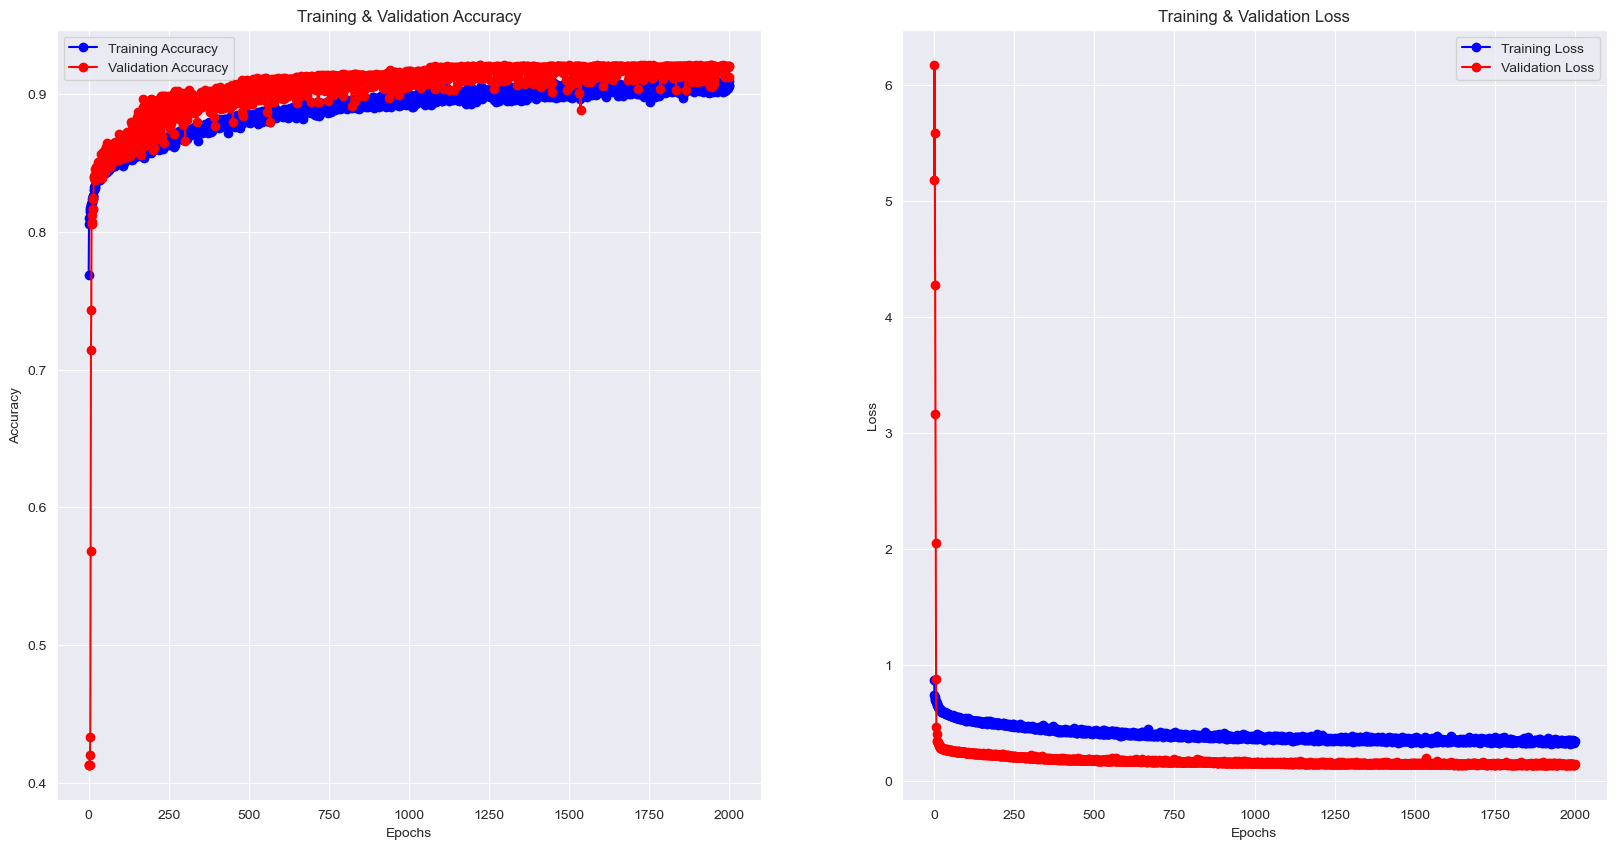

In [77]:
epochs = range(n_epochs)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'bo-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'b-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

(0.82, 0.95)

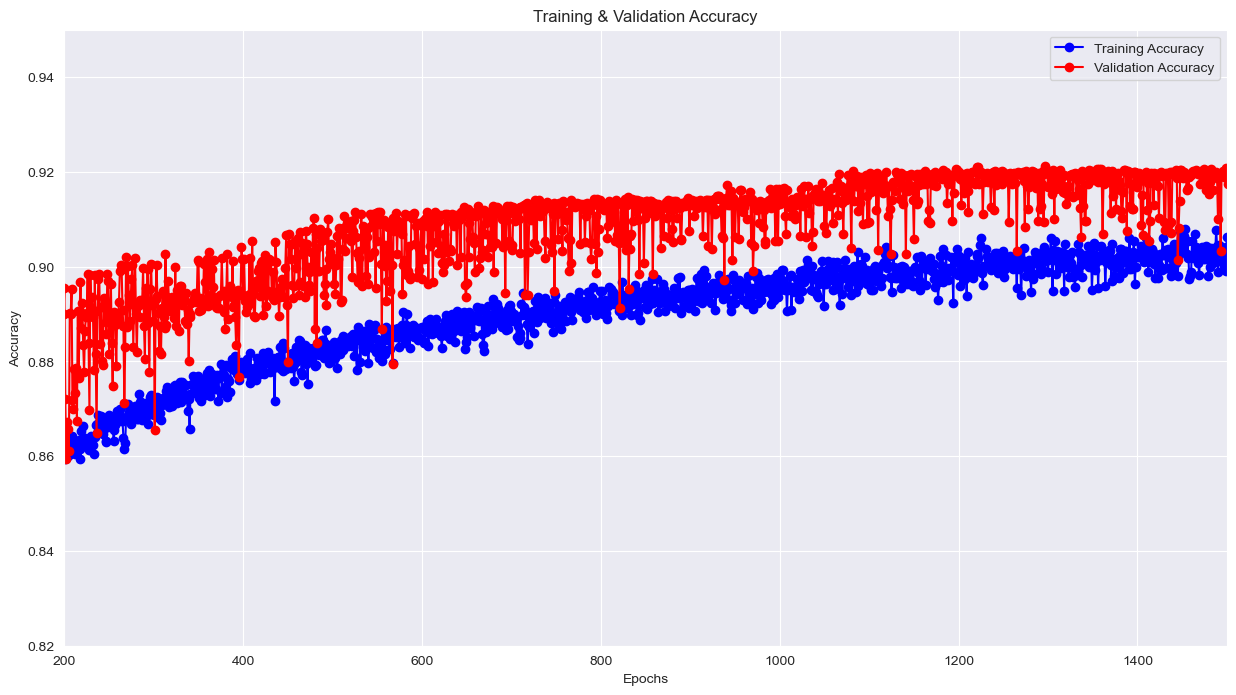

In [78]:
plt.figure(figsize=(15, 8))

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xlim(200, 1500) 
plt.ylim(0.82,0.95)

In [79]:
#Get the prediction probabilities for each class
pred_probs = dnn_model.predict(x_ts)

# Get the predicted class labels by selecting the class with the highest probability
DNN_predictions = np.argmax(pred_probs, axis=1)

# Print the prediction labels
print(DNN_predictions)

573/573 [==============================] - 1s 1ms/step
[1 0 1 ... 1 0 1]


In [80]:
error_dnn = (DNN_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_dnn))

Test error: 8.8%


<Axes: title={'center': 'Deep Neural Network'}>

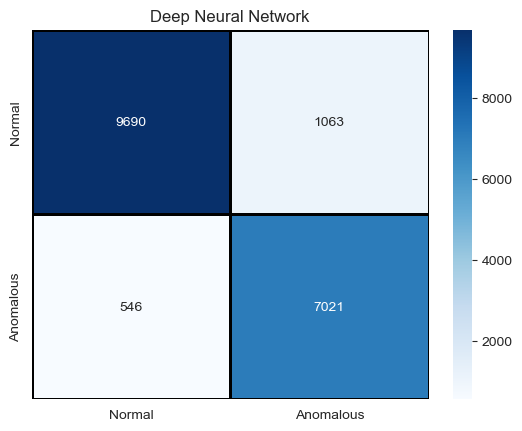

In [81]:
cm = confusion_matrix(y_ts,DNN_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Deep Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

In [82]:
print("MAE",mean_absolute_error(y_ts,DNN_predictions))
print("Accuracy", accuracy_score(y_ts, DNN_predictions))
print("Precision", precision_score(y_ts, DNN_predictions, average='weighted', labels=np.unique(DNN_predictions)))
print("Recall", recall_score(y_ts, DNN_predictions, average='weighted', labels=np.unique(DNN_predictions)))
print("F1", f1_score(y_ts, DNN_predictions, average='weighted', labels=np.unique(DNN_predictions)))
print("ROC AUC", roc_auc_score(y_ts, DNN_predictions, average='weighted', labels=np.unique(DNN_predictions)))
error_sgd = (DNN_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_sgd))

MAE 0.08782751091703057
Accuracy 0.9121724890829694
Precision 0.9143780122360986
Recall 0.9121724890829694
F1 0.912541412185835
ROC AUC 0.9144942275859939
Test error: 8.8%


Minimum Validation Loss: 0.1429


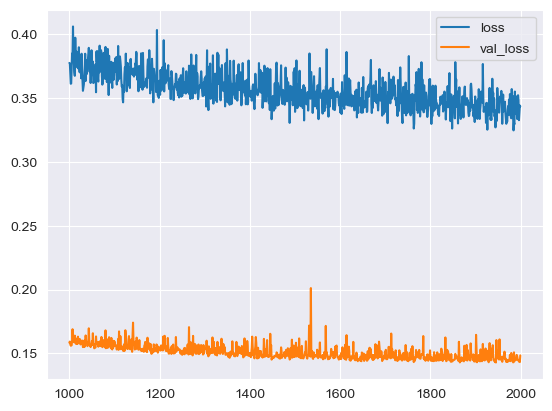

In [83]:
# Start the plot at epoch 1000
history_df = pd.DataFrame(history.history)
history_df.loc[1000:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));